In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os, sys
# This enables us to import Python libraries in the folder.
sys.path.insert(0, "/content/gdrive/My Drive/Stat 157 Project/") 
sys.path.insert(0, "/content/gdrive/My Drive/Stat 157 Project/iterative-Random-Forest") 
root_folder = "/content/gdrive/My Drive/Stat 157 Project/"

In [0]:
!pip install umap

In [0]:
!pip install -e "/content/gdrive/My Drive/Stat 157 Project/iterative-Random-Forest"

Obtaining file:///content/gdrive/My%20Drive/Stat%20157%20Project/iterative-Random-Forest
  Found existing installation: irf 0.2.1
    Can't uninstall 'irf'. No files were found to uninstall.
  Running setup.py develop for irf


In [0]:
!pip list | grep irf

irf                      0.2.1           /content/gdrive/My Drive/Stat 157 Project/iterative-Random-Forest


In [0]:
!python "/content/gdrive/My Drive/Stat 157 Project/iterative-Random-Forest/irf/tests/test_irf_utils.py"
!python "/content/gdrive/My Drive/Stat 157 Project/iterative-Random-Forest/irf/tests/test_irf_weighted.py"

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [0]:
import numpy as np
from irf import irf_utils
from irf.ensemble import RandomForestClassifierWithWeights
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

# Data Preprocessing

In [0]:
#data = pd.read_csv(root_folder+"Data_for_Class_Project.csv")
data = pd.read_csv(root_folder+"Data_for_Class_Project_updated_4-27-20.csv")

In [0]:
rnai_data = data.iloc[:,2:110]
chip_data = data.iloc[:,110:468]
rbp_data = data.iloc[:,468:488]

In [0]:
data.shape

(15669, 489)

In [0]:
data.head()

,Current ID,current_symbol,AP.2_0.1.5,AP.2_10.12,AP.2_16.18,scrt_0.1.5,scrt_10.12,scrt_16.18,Blimp.1_10.12,Blimp.1_16.18,kay_10.12,kay_16.18,bsh_10.12,bsh_16.18,ERR_10.12,ERR_16.18,Xbp1_10.12,Xbp1_16.18,cad_0.1.5,cad_16.18,cad_2.4,CG15696_0.1.5,CG15696_16.18,CG15696_2.4,gfzf_16.18,gfzf_2.4,SuHW_16.18,SuHW_2.4,CG2120_14.16,CG2120_16.18,Pdp1_14.16,Pdp1_16.18,CG33557_16.18,CG33557_6.8,dmrt99B_16.18,dmrt99B_6.8,CG3476_10.12,CG3476_16.18,rgr_10.12,rgr_16.18,...,Chip.fd64A,Chip.en,Chip.exex,Chip.fd102C,Chip.lab,Chip.ftz.f1,Chip.Ets21C,Chip.foxo.y,Chip.Meics,Chip.CG3032,Chip.dmrt99B,Chip.ss.x,Chip.Trl,Chip.CG15011,Chip.CG10543,Chip.ems,Chip.ss.y,Chip.CG1529,Chip.Sry.δ,RBP.B52,RBP.Upf1,RBP.Srp54,RBP.elav,RBP.ps,RBP.U2af50,RBP.CG17838,RBP.qkr58E.1,RBP.Rbp1,RBP.SF2,RBP.Rm62,RBP.qkr54B,RBP.SC35,RBP.tra2,RBP.mub,RBP.msi,RBP.Fmr1,RBP.Cbp20,RBP.snRNP.U1.70K,RBP.CG6227,Is_smORF
0,FBgn0000003,7SLRNA:CR32864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0
1,FBgn0000008,a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,206.707657,466.929248,94.168439,0.0,203.390308,196.574274,171.866069,176.933736,257.227716,107.461262,0.0,0.0,0.0,538.126738,0.0,0.0,0.000000,0.0,2.042078,0.0,2.236034,0.000000,0.0,0.0,2.078959,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0
2,FBgn0000014,abd-A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0
3,FBgn0000015,Abd-B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0
4,FBgn0000017,Abl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.984548,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.620566,0.0,0.000000,0.0,0.000000,1.775852,0.0,0.0,1.663713,0.0,1.842625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.521312,1.828734,0


In [0]:
rnai_data.describe()

,AP.2_0.1.5,AP.2_10.12,AP.2_16.18,scrt_0.1.5,scrt_10.12,scrt_16.18,Blimp.1_10.12,Blimp.1_16.18,kay_10.12,kay_16.18,bsh_10.12,bsh_16.18,ERR_10.12,ERR_16.18,Xbp1_10.12,Xbp1_16.18,cad_0.1.5,cad_16.18,cad_2.4,CG15696_0.1.5,CG15696_16.18,CG15696_2.4,gfzf_16.18,gfzf_2.4,SuHW_16.18,SuHW_2.4,CG2120_14.16,CG2120_16.18,Pdp1_14.16,Pdp1_16.18,CG33557_16.18,CG33557_6.8,dmrt99B_16.18,dmrt99B_6.8,CG3476_10.12,CG3476_16.18,rgr_10.12,rgr_16.18,slou_10.12,slou_16.18,...,foxo_16.18,Sox15_10.12,Sox15_16.18,nau_0.1.5,nau_12.14,nau_16.18,onecut_0.1.5,onecut_12.14,onecut_16.18,scro_0.1.5,scro_12.14,scro_16.18,ss_12.14,ss_16.18,CG17181_0.1.5,CG17181_16.18,CG17181_8.10,HLH54f_0.1.5,HLH54f_16.18,HLH54f_8.10,pb_16.18,pb_8.10,esn_0.1.5,esn_14.16,esn_16.18,repo_14.16,repo_16.18,sens2_14.16,sens2_16.18,sens_16.18,sens_6.8,Sox14_6.8,trh_16.18,trh_6.8,Hr46_12.14,Hr46_16.18,Sox102F_12.14,Sox102F_16.18,Zfh2_12.14,Zfh2_16.18
count,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,...,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000
mean,-0.000048,0.000466,-0.000614,-0.000225,0.000133,-0.001307,0.000076,-0.000092,-0.005293,0.022625,0.000054,-0.002021,-0.002592,-0.001179,-0.000295,0.007570,0.000322,-0.000175,-0.000033,0.001540,0.003384,0.008221,-0.000057,0.000099,0.016485,0.008948,-0.000132,-0.000468,0.015044,0.003233,0.025896,0.112816,0.157124,0.000427,-0.000119,-0.000389,0.000094,0.000126,0.000156,0.000280,...,-0.001038,0.006912,-0.001915,-0.000113,0.002111,0.002683,-0.000059,-0.032353,-0.087895,-0.000050,0.161370,-0.001692,0.000192,-0.006410,-0.000428,0.019750,0.089766,-0.000136,-0.000339,-0.000969,-0.001293,-0.000195,-0.002216,-0.000362,-0.000588,-0.005861,0.000248,-0.002194,-0.003330,-0.002670,-0.000099,0.000050,-0.001297,0.000809,0.000056,0.000003,0.001252,0.002045,-0.000349,-0.000794
std,0.005993,0.058784,0.111659,0.014194,0.040869,0.059843,0.009519,0.011494,0.152036,0.238989,0.012523,0.064130,0.066783,0.042015,0.031078,0.144860,0.029000,0.067817,0.021275,0.041901,0.120203,0.132275,0.015887,0.012426,0.190345,0.201730,0.033885,0.081711,0.147633,0.091482,0.200032,0.380560,0.628099,0.047608,0.014326,0.034666,0.019340,0.014504,0.024309,0.090664,...,0.046440,0.119004,0.076050,0.010046,0.074265,0.084080,0.007393,0.221393,0.359964,0.006244,0.478348,0.051450,0.019589,0.096535,0.019022,0.166091,0.323862,0.012024,0.025957,0.044587,0.046298,0.036226,0.096370,0.021371,0.038536,0.097854,0.027387,0.092322,0.131625,0.134632,0.043689,0.040920,0.124232,0.058101,0.007040,0.008765,0.062395,0.083917,0.025956,0.101711
min,-0.750158,-2.706797,-2.466830,-1.051305,-1.570956,-2.456490,0.000000,-1.438788,-4.290664,-4.254569,-0.935196,-1.887567,-2.705048,-1.407162,-2.647580,-3.863078,-1.371468,-3.118173,-1.748250,-0.766192,-3.178467,-1.614831,-1.357885,0.000000,-5.810840,-1.645595,-1.660868,-4.869706,-3.146793,-2.247705,-3.254872,-5.654274,-5.641487,-1.497067,-1.087896,-1.160286,-1.355795,-0.804355,-1.230114,-3.556570,...,-3.594647,-3.839134,-3.398093,-0.948578,-1.440966,-1.371155,-0.925413,-4.571782,-5.050885,-0.781536,-3.185854,-1.956956,-0.768399,-3.033092,

In [0]:
chip_data.describe()

,Chip.fd3F,Chip.insv.x,Chip.CG18764,Chip.grn,Chip.CG3407,Chip.dpn.x,Chip.ovo,Chip.CG30020,Chip.CG10267,Chip.Deaf1,Chip.CG1602,Chip.CG13624,Chip.CG18619,Chip.Hr39,Chip.CG16863,Chip.crp.x,Chip.sv,Chip.CG17181,Chip.achi,Chip.CG8944,Chip.Clk,Chip.Hr4,Chip.CG34367,Chip.CG17359,Chip.ac,Chip.E.spl.m8.HLH,Chip.Hmx,Chip.CG10669,Chip.Myb,Chip.sima,Chip.CG31627,Chip.CrebB,Chip.salr.x,Chip.CG4328,Chip.CG1233,Chip.twi,Chip.EcR,Chip.Dp,Chip.Rel.x,Chip.run,...,Chip.CG13775,Chip.CG9817,Chip.D19B,Chip.vfl,Chip.CG5204,Chip.gcm,Chip.pita,Chip.CG4854.y,Chip.CG12942,Chip.oc,Chip.HHEX,Chip.CG2678,Chip.fu2,Chip.B.H2,Chip.schlank,Chip.woc,Chip.NfI,Chip.acj6,Chip.CG33213,Chip.CG6808,Chip.usp,Chip.fd64A,Chip.en,Chip.exex,Chip.fd102C,Chip.lab,Chip.ftz.f1,Chip.Ets21C,Chip.foxo.y,Chip.Meics,Chip.CG3032,Chip.dmrt99B,Chip.ss.x,Chip.Trl,Chip.CG15011,Chip.CG10543,Chip.ems,Chip.ss.y,Chip.CG1529,Chip.Sry.δ
count,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,...,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000
mean,30.137959,109.391877,25.986121,23.459963,31.396828,48.255721,18.476925,78.667275,175.779288,218.605674,31.070105,24.552129,44.099085,46.532415,24.021820,7.114249,15.750575,33.882080,70.449945,22.667261,11.236066,37.791859,39.584770,87.775245,11.484526,49.034583,6.704059,53.419681,66.377531,3.477365,53.672058,29.228317,23.285137,27.859373,62.946643,47.796223,107.429278,272.083341,4.614130,16.637665,...,63.594529,57.872683,30.410906,10.473017,9.064899,45.009096,29.031335,16.710804,18.076195,27.236378,44.489086,168.203099,12.158428,29.566062,18.436530,33.399464,69.932607,39.470862,25.147479,72.654439,193.912173,19.578180,6.755099,87.812647,8.581711,99.399892,16.275811,26.925143,101.669810,75.265620,78.510873,73.687355,37.609065,23.417524,23.270905,70.094303,22.872967,67.708519,27.660692,129.489534
std,132.798314,652.786824,108.787068,88.431182,245.617509,172.570876,61.042939,394.383596,551.171321,1210.108197,125.587340,86.893674,174.423918,205.384183,119.979482,35.016176,61.766652,155.572906,333.550565,100.788062,51.877725,166.110349,176.616637,356.183827,60.880485,198.654680,37.035721,261.970447,264.577965,23.842508,215.760293,121.064408,107.528305,116.507926,251.921907,186.795669,485.063475,866.407438,27.074169,82.018015,...,337.028154,242.770632,171.493153,42.847815,49.169718,178.846610,221.270798,72.713670,71.779344,123.071387,183.468828,757.780924,52.396551,107.849296,90.917239,121.782867,264.959438,165.072296,84.981991,555.556334,862.463122,102.559310,36.204362,323.668953,49.123773,390.800563,62.006684,131.791900,388.993314,360.711227,315.487400,366.944236,167.885626,89.175513,121.681595,226.092055,92.522994,293.154516,129.670196,440.728872
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.

In [0]:
rbp_data.describe()

,RBP.B52,RBP.Upf1,RBP.Srp54,RBP.elav,RBP.ps,RBP.U2af50,RBP.CG17838,RBP.qkr58E.1,RBP.Rbp1,RBP.SF2,RBP.Rm62,RBP.qkr54B,RBP.SC35,RBP.tra2,RBP.mub,RBP.msi,RBP.Fmr1,RBP.Cbp20,RBP.snRNP.U1.70K,RBP.CG6227
count,15669.000000,15669.000000,15669.0,15669.0,15669.000000,15669.000000,15669.000000,15669.0,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.000000,15669.0,15669.000000,15669.000000,15669.000000,15669.000000
mean,0.432461,0.239398,inf,inf,0.505340,0.252559,0.939866,inf,0.207254,0.226747,0.176997,0.227125,0.194381,0.179170,0.274144,inf,0.088236,0.091979,0.075969,0.057392
std,1.427352,0.747639,NaN,NaN,3.265134,0.979100,57.237616,NaN,0.744362,0.829729,0.619573,0.894717,0.884752,0.818706,2.900191,NaN,0.420189,0.540446,1.013239,0.357544
min,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,27.469912,18.284843,inf,inf,210.285645,57.459797,7137.394528,inf,18.778412,12.106308,13.237626,22.027576,29.296366,17.276869,256.493700,inf,6.882004,12.114399,84.527922,11.132456


In [0]:
#rnaI - number is fold change, 
#chip seq - look at order statistics.
#Is_smorf is binary variable

# Prediction of HOTness

- Paper looked at RNP data, would be cool to predict HOTness from rnai, chip-seq, without having access to RBP Data. Then, visualize activations in deep network.
- HOT RNAs are involved in RNA-splicing, RNA-i, NMD 
- Application to metagenomic setting, you sequence a bunch of unknown things, do chip-seq, rna-i assays, and want to learn what sort of samples you're dealing with.
- Look at important features correlated with RNA Hotness or not, between models.

Questions:
- How to best subsample? Oversampling and fitting a logistic regression model is doing better than Vanilla Neural Network on balanced subsamples. 

Notes:
- Class Imbalance, there are only 226 HOT RNAs, which is about 1.5% of the data.
1) Creating synthetic data based on some distance metric. SMOTE: Synthetic Minority Over-sampling
2) Resample unbalanced dataset, into N smaller batches that are balanced. Then train an ensemble of N classifiers on each of these N smaller batches.
3) 2) but with different ratios, i.e. doesn't have to be balanced.
4) Using a different evaluation metric i.e. Precision, Recall, F1...

Will try last 3 for now.

In [0]:
hot_labels = pd.read_csv(root_folder+"SuppTable_7_-_HOT_RNA_Gene_Names.csv", header=None)
hot_labels.columns = ["current_symbol"]
hot_labels.head()

,current_symbol
0,Aac11
1,Aats-cys
2,Aats-glupro
3,Acn
4,AGO2


In [0]:
hot_labels.shape

(282, 1)

In [0]:
#Not all hot labels are in this dataset?
np.sum(data["current_symbol"].isin(hot_labels["current_symbol"]))

226

In [0]:
data["HOT"] = data["current_symbol"].isin(hot_labels["current_symbol"])*1

#For troubleshooting rbp data
#hot_rbp_subset = data[data["current_symbol"].isin(hot_labels["current_symbol"])].iloc[:,np.r_[0,1,468:488]]

#Splitting data according to hot label
hot_subset = data[data["current_symbol"].isin(hot_labels["current_symbol"])].iloc[:, np.r_[2:468,489]]
not_hot_subset = data[~data["current_symbol"].isin(hot_labels["current_symbol"])].iloc[:, np.r_[2:468,489]]
hot_subset_matrix, not_hot_subset_matrix = hot_subset.values, not_hot_subset.values

In [0]:
#Ranked Chip-Data
data_rankedchip = data.iloc[:,2:468].values.copy()
for i in np.arange(108,466):
  data_rankedchip[:,i] = rankdata(data_rankedchip[:,i])

In [0]:
#Obtaining test set.
num_not_hot = not_hot_subset_matrix.shape[0]
num_hot = hot_subset_matrix.shape[0]
num_test = int(0.2*num_hot)
n_pred = not_hot_subset_matrix.shape[1] - 1

#Shuffling
shuffled_not_hot_idx = np.random.permutation(num_not_hot)
shuffled_hot_idx = np.random.permutation(num_hot)
test_not_hot_idx, test_hot_idx = shuffled_not_hot_idx[:num_test], shuffled_hot_idx[:num_test]
data_hot_idx, data_not_hot_idx = np.delete(np.arange(num_hot), test_hot_idx), np.delete(np.arange(num_not_hot), test_not_hot_idx)

#Partitioning 
test_not_hot = not_hot_subset_matrix[test_not_hot_idx, :]
test_hot = hot_subset_matrix[test_hot_idx, :]
data_not_hot = not_hot_subset_matrix[data_not_hot_idx, :]
data_hot = hot_subset_matrix[data_hot_idx, :]
test_set = np.vstack((test_not_hot, test_hot))
test_predictors = test_set[:,:-1]
test_labels = test_set[:,-1]

In [0]:
from scipy.stats import rankdata

In [0]:
#Oversampling HOT DNA
bootstrap_idx = np.random.choice(np.arange(data_hot.shape[0]), size = data_not_hot.shape[0], replace = True)
oversampled_hot_matrix = data_hot[bootstrap_idx, :]
oversampled_hot_dataset = np.vstack((oversampled_hot_matrix, data_not_hot))
num_data = oversampled_hot_dataset.shape[0]
oversampled_hot_dataset = oversampled_hot_dataset[np.random.permutation(num_data),:] #Shuffling rows

#Ranked Chip-Data
oversampled_hot_dataset_rankedchip = oversampled_hot_dataset.copy()
for i in np.arange(108,466):
  oversampled_hot_dataset_rankedchip[:,i] = rankdata(oversampled_hot_dataset_rankedchip[:,i])

# UMAP

In [0]:
import umap.umap_ as umap
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(data.iloc[:,2:468].values)
embedding.shape

(15669, 2)

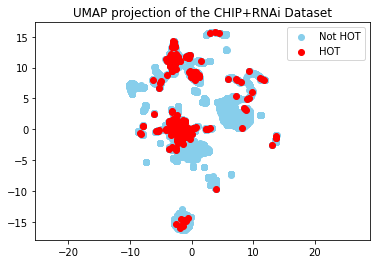

In [0]:
#plt.figure(figsize = (10,10))
plt.scatter(embedding[:, 0][data.iloc[:,489].values==0], embedding[:, 1][data.iloc[:,489].values==0], c='skyblue', label = "Not HOT")
plt.scatter(embedding[:, 0][data.iloc[:,489].values==1], embedding[:, 1][data.iloc[:,489].values==1], c='red', label = "HOT")
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the CHIP+RNAi Dataset')
plt.legend()
plt.savefig(root_folder+"UMAP projection.png");

In [0]:
reducer_ranked = umap.UMAP()
embedding_ranked = reducer_ranked.fit_transform(data_rankedchip)
embedding_ranked.shape

(15669, 2)

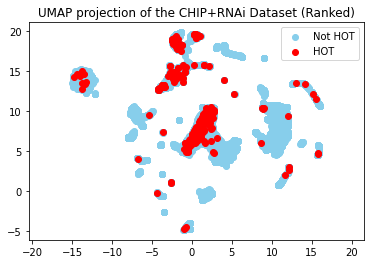

In [0]:
plt.scatter(embedding_ranked[:, 0][data.iloc[:,489].values==0], embedding_ranked[:, 1][data.iloc[:,489].values==0], c='skyblue', label = "Not HOT")
plt.scatter(embedding_ranked[:, 0][data.iloc[:,489].values==1], embedding_ranked[:, 1][data.iloc[:,489].values==1], c='red', label = "HOT")
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the CHIP+RNAi Dataset (Ranked)')
plt.legend()
plt.savefig(root_folder+"UMAP projection (Ranked).png");

# Baseline model: Logistic Regression
- Oversampled HOT DNA dataset 70X, each sample on average would appear 70 times... there are overfitting concerns, but I don't want to throw away data.
- Baseline model: can compare feature importance as evaluated by the coefficients of predictors in Logistic regression, with other models.

In [0]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import uniform

In [0]:
X,y = oversampled_hot_dataset[:,:-1], oversampled_hot_dataset[:,-1]
oversampled_logistic = LogisticRegressionCV(Cs = np.geomspace(1e-2, 1e2, 10), solver='saga', penalty = 'l2', max_iter=100, \
                                            random_state=3, n_jobs = -1).fit(StandardScaler().fit_transform(X), y)
# distributions = dict(C=uniform(loc=0, scale=4))
# clf = GridSearchCV(logistic, distributions, random_state=0)
# search = clf.fit(MinMaxScaler().fit_transform(X), y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

In [0]:
oversampled_logistic.score(StandardScaler().fit_transform(X),y)

0.8710546824262891

In [0]:
oversampled_logistic.C_

array([100.])

In [0]:
oversampled_logistic.score(StandardScaler().fit_transform(test_predictors),test_labels)

0.7555555555555555

In [0]:
def feat_importance(X, y, X_test, y_test, repeats, model):
  """Calculates permutation feature importance for sklearn models."""

  num_obs, num_feat = X.shape
  test_acc_orig = model.score(StandardScaler().fit_transform(X_test), y_test)
  train_acc_orig = model.score(StandardScaler().fit_transform(X), y)
  train_importances = np.empty((repeats, num_feat))
  test_importances = np.empty((repeats, num_feat))

  for rep in np.arange(repeats):
    for feat in np.arange(num_feat):
      shuffled_train_idx, shuffled_test_idx = np.random.permutation(num_obs), np.random.permutation(X_test.shape[0])
      X_perm = X.copy()
      test_perm = X_test.copy()
      X_perm[:,feat] = X_perm[:,feat][shuffled_train_idx]
      test_perm[:,feat] = test_perm[:,feat][shuffled_test_idx]

      test_acc = model.score(StandardScaler().fit_transform(test_perm), y_test)
      train_acc = model.score(StandardScaler().fit_transform(X_perm), y)
      train_feat_importance = train_acc/train_acc_orig
      test_feat_importance = test_acc/test_acc_orig 
      train_importances[rep, feat] = train_feat_importance
      test_importances[rep, feat] = test_feat_importance
    print("Iteration "+str(rep))
  return train_importances, test_importances

In [0]:
log_train_importances, log_test_importances = feat_importance(X,y,test_predictors, test_labels, 10, oversampled_logistic)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9


In [0]:
np.savetxt(root_folder+"log_train_importances.csv", log_train_importances, delimiter=",")
np.savetxt(root_folder+"log_test_importances.csv", log_test_importances, delimiter=",")

In [0]:
log_train_importances, log_test_importances = pd.read_csv(root_folder+"log_train_importances.csv", header= None).values, \
                                              pd.read_csv(root_folder+"log_test_importances.csv", header = None).values

In [0]:
log_impt_train_feat_idx = np.argsort(np.mean(1/log_train_importances,axis = 0))[::-1][:10] 
log_impt_test_feat_idx = np.argsort(np.mean(1/log_test_importances,axis = 0))[::-1][:10]

# Vanilla Neural Network for classification
- Ensembling shallow MLP's, with each MLP trained on a separate balanced subset of data of size 454. 
- Current accuracy is low. not much better than random guessing. Need to tune hyperparmeters.
- Also need to consider how to do activation maximization analysis on an ensemble.

In [0]:
from sklearn.neural_network import MLPClassifier

In [0]:
mlp = MLPClassifier(hidden_layer_sizes=(50,50,50,50), max_iter=20, alpha=1e-3,
                    solver='adam', verbose=10, random_state=1, tol = 1e-3,
                    learning_rate_init=.1, early_stopping = True, validation_fraction = 0.1)


In [0]:
mlp.fit(X,y)

Iteration 1, loss = inf
Validation score: 0.709416
Iteration 2, loss = 0.57788552
Validation score: 0.720130
Iteration 3, loss = 0.56278957
Validation score: 0.737987
Iteration 4, loss = 0.55353710
Validation score: 0.738636
Iteration 5, loss = 0.53516559
Validation score: 0.745455
Iteration 6, loss = 0.57391835
Validation score: 0.747078
Iteration 7, loss = inf
Validation score: 0.701299
Iteration 8, loss = 0.59428433
Validation score: 0.712987
Iteration 9, loss = 0.58487894
Validation score: 0.706169
Iteration 10, loss = inf
Validation score: 0.733117
Iteration 11, loss = 0.55194574
Validation score: 0.759416
Iteration 12, loss = 0.53699750
Validation score: 0.764286
Iteration 13, loss = 0.53615334
Validation score: 0.745779
Iteration 14, loss = 0.54337525
Validation score: 0.741234
Iteration 15, loss = inf
Validation score: 0.581818
Iteration 16, loss = 0.64701979
Validation score: 0.624675
Iteration 17, loss = 0.63834414
Validation score: 0.629870
Iteration 18, loss = 0.63615741
Va

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(50, 50, 50, 50), learning_rate='constant',
              learning_rate_init=0.1, max_fun=15000, max_iter=20, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='adam', tol=0.001,
              validation_fraction=0.1, verbose=10, warm_start=False)

In [0]:
mlp.score(X,y)

0.7603584881153397

In [0]:
mlp.score(test_predictors, test_labels)

0.7666666666666667

In [0]:
mlp_train_importances, mlp_test_importances = feat_importance(X,y,test_predictors, test_labels, 10, mlp)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9


In [0]:
np.savetxt(root_folder+"mlp_train_importances.csv", mlp_train_importances, delimiter=",")
np.savetxt(root_folder+"mlp_test_importances.csv", mlp_test_importances, delimiter=",")

In [0]:
mlp_train_importances, mlp_test_importances = pd.read_csv(root_folder+"mlp_train_importances.csv", header= None).values, \
                                              pd.read_csv(root_folder+"mlp_test_importances.csv", header = None).values

In [0]:
mlp_impt_train_feat_idx = np.argsort(np.mean(1/mlp_train_importances,axis = 0))[::-1][:10]
mlp_impt_test_feat_idx = np.argsort(np.mean(1/mlp_test_importances,axis = 0))[::-1][:10]

In [0]:
mlp_impt_train_feat_idx, mlp_impt_test_feat_idx

(array([ 46,  75,  28, 449,  54,  56, 159,  32, 463, 388]),
 array([ 40, 464,  51, 274, 409,  84, 325, 216, 406, 412]))

# Summary of important features

In [0]:
np.sort(np.mean(1/mlp_test_importances,axis = 0))[::-1][:10]

array([1.02092199, 1.01875   , 1.01875   , 1.01875   , 1.01666667,
       1.01458333, 1.01458333, 1.01458333, 1.01258333, 1.0125    ])

In [0]:
mlp_feat_df = pd.DataFrame(data = {"Feature": data.columns.values[2:468][mlp_impt_test_feat_idx], \
                                    "Mean Importance": np.mean(1/mlp_test_importances,axis = 0)[mlp_impt_test_feat_idx],\
                                    "Std": np.std(1/mlp_test_importances,axis = 0)[mlp_impt_test_feat_idx]})
mlp_feat_df["CV"] = mlp_feat_df["Std"] / mlp_feat_df["Mean Importance"]
mlp_feat_df

,Feature,Mean Importance,Std,CV
0,CG9305_16.18,1.020922,0.009517,0.009322
1,Chip.CG1529,1.018750,0.006250,0.006135
2,CG32006_12.14,1.018750,0.006250,0.006135
3,Chip.bigmax,1.018750,0.006250,0.006135
4,Chip.pfk,1.016667,0.008333,0.008197
5,CG17181_8.10,1.014583,0.009547,0.009410
6,Chip.cg,1.014583,0.009547,0.009410
7,Chip.Pdp1.x,1.014583,0.009547,0.009410
8,Chip.MESR4,1.012583,0.013619,0.013450
9,Chip.Ets97D,1.012500,0.010206,0.010080


In [0]:
log_feat_df = pd.DataFrame(data = {"Feature": data.columns.values[2:468][log_impt_test_feat_idx], \
                                    "Mean Importance": np.mean(1/log_test_importances,axis = 0)[log_impt_test_feat_idx],\
                                    "Std": np.std(1/log_test_importances,axis = 0)[log_impt_test_feat_idx]})
log_feat_df["CV"] = log_feat_df["Std"] / log_feat_df["Mean Importance"]
log_feat_df

,Feature,Mean Importance,Std,CV
0,caup_16.18,1.198492,0.064464,0.053787
1,caup_10.12,1.082204,0.034925,0.032272
2,Chip.CG10147,1.065854,0.041807,0.039223
3,Chip.MESR4,1.053200,0.024529,0.023290
4,Chip.corto,1.051464,0.022084,0.021003
5,Chip.pzg,1.046744,0.024778,0.023671
6,CG9876_16.18,1.045455,0.030783,0.029445
7,Chip.salr.x,1.043281,0.018802,0.018022
8,Chip.eyg,1.043135,0.014201,0.013614
9,Chip.gcm2,1.041989,0.025921,0.024877


# Keras Ensemble Models (Poor performance)

In [0]:
def mlp_binary(input_size, n_layers, n_hidden, activation = "relu"):
  model = tf.keras.Sequential()
  model.add(keras.layers.Dense(n_hidden, input_dim=input_size, activation = activation))
  for _ in np.arange(n_layers):
    model.add(keras.layers.Dense(n_hidden))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation(activation))
    model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(2, activation='softmax'))
  return model

In [0]:
np.random.seed(3)
n_models = 50
models = list()
data_num_not_hot = data_not_hot.shape[0]
data_num_hot = data_hot.shape[0]
n_pred = data_hot.shape[1] - 1

# One balanced subset for each model
for _ in range(n_models):

  #Sampling balanced subset of data
  shuffled_idx = np.random.permutation(data_num_not_hot)
  sampled_not_hot = data_not_hot[shuffled_idx[:data_num_hot],:]
  balanced_sample = np.vstack((sampled_not_hot, data_hot))
  balanced_sample_predictors = balanced_sample[:,:-1]
  balanced_sample_labels = balanced_sample[:,-1]
  X_train, X_val, y_train, y_val = train_test_split(balanced_sample_predictors, balanced_sample_labels, test_size=0.2, random_state=42)

	#Define model
  model = mlp_binary(n_pred, 5, 100)
  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
  
  #Saving model weights
  model_checkpoint_path = root_folder+"models/mlp{}.ckpt".format(_)
  model_cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_checkpoint_path, save_weights_only=True, verbose=1)

  #Fit model
  model.fit(X_train, y_train, epochs=100, batch_size=50, validation_data=(X_val, y_val), callbacks = [model_cp_callback])

	# store model in memory as ensemble member
  models.append(model)


In [0]:
# make predictions
yhats = np.array([model.predict(test_predictors) for model in models])
ensembled_yhats = np.argmax(np.mean(yhats, axis = 0), axis = 1)


In [0]:
np.sum((ensembled_yhats-test_labels)==0)/len(test_labels)

0.4777777777777778

# Iterative Random Forests

- Did a sanity check, confirmed that iRF in which training set had labels found the important feature. 

In [0]:
X_train,y_train = oversampled_hot_dataset[:,:-1], oversampled_hot_dataset[:,-1]
X_test,y_test = test_predictors, test_labels

In [0]:
all_rf_weights, all_K_iter_rf_data, \
    all_rf_bootstrap_output, all_rit_bootstrap_output, \
    stability_score = irf_utils.run_iRF(X_train=X_train,
                                        X_test=X_test,
                                        y_train=y_train,
                                        y_test=y_test,
                                        K=7,                          # number of iteration
                                        rf = RandomForestClassifierWithWeights(n_estimators=200),
                                        B=30,
                                        random_state_classifier=2018, # random seed
                                        propn_n_samples=.2,
                                        bin_class_type=1,
                                        M=20,
                                        max_depth=5,
                                        noisy_split=False,
                                        num_splits=2,
                                        n_estimators_bootstrap=5)

In [0]:
all_K_iter_rf_data["rf_iter7"]["rf_validation_metrics"]

{'accuracy_score': 0.9333333333333333, 'confusion_matrix': array([[45,  0],
        [ 6, 39]]), 'f1_score': 0.9285714285714286, 'hamming_loss': 0.06666666666666667, 'log_loss': 2.3025850929940463, 'precision_score': 1.0, 'recall_score': 0.8666666666666667, 'zero_one_loss': 0.06666666666666665}

In [0]:
y_test.shape

(90,)

In [0]:
all_K_iter_rf_data["rf_iter7"].keys()

dict_keys(['get_params', 'rf_validation_metrics', 'feature_importances', 'feature_importances_std', 'feature_importances_rank_idx', 'dtree0', 'dtree1', 'dtree2', 'dtree3', 'dtree4', 'dtree5', 'dtree6', 'dtree7', 'dtree8', 'dtree9', 'dtree10', 'dtree11', 'dtree12', 'dtree13', 'dtree14', 'dtree15', 'dtree16', 'dtree17', 'dtree18', 'dtree19', 'dtree20', 'dtree21', 'dtree22', 'dtree23', 'dtree24', 'dtree25', 'dtree26', 'dtree27', 'dtree28', 'dtree29', 'dtree30', 'dtree31', 'dtree32', 'dtree33', 'dtree34', 'dtree35', 'dtree36', 'dtree37', 'dtree38', 'dtree39', 'dtree40', 'dtree41', 'dtree42', 'dtree43', 'dtree44', 'dtree45', 'dtree46', 'dtree47', 'dtree48', 'dtree49', 'dtree50', 'dtree51', 'dtree52', 'dtree53', 'dtree54', 'dtree55', 'dtree56', 'dtree57', 'dtree58', 'dtree59', 'dtree60', 'dtree61', 'dtree62', 'dtree63', 'dtree64', 'dtree65', 'dtree66', 'dtree67', 'dtree68', 'dtree69', 'dtree70', 'dtree71', 'dtree72', 'dtree73', 'dtree74', 'dtree75', 'dtree76', 'dtree77', 'dtree78', 'dtree79'

In [0]:
all_K_iter_rf_data["rf_iter7"]['get_params']

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [0]:
test = RandomForestClassifierWithWeights()
test.fit(X_train, y_train, feature_weight = all_rf_weights['rf_weight7'])

RandomForestClassifierWithWeights(bootstrap=True, ccp_alpha=0.0,
                                  class_weight=None, criterion='gini',
                                  max_depth=None, max_features='auto',
                                  max_leaf_nodes=None, max_samples=None,
                                  min_impurity_decrease=0.0,
                                  min_impurity_split=None, min_samples_leaf=1,
                                  min_samples_split=2,
                                  min_weight_fraction_leaf=0.0,
                                  n_estimators=100, n_jobs=None,
                                  oob_score=False, random_state=None, verbose=0,
                                  warm_start=False)

In [0]:
print(stability_score)

{'55_65_116_136_216_258_285_318_337_339_356_367_401_406_444': 0.03333333333333333, '55_136_337_356_444': 0.03333333333333333, '55': 0.9333333333333333, '55_136_337': 0.1, '55_136': 0.4, '25_30_55_56_65_116_206_260_393': 0.03333333333333333, '55_56_260': 0.1, '55_56': 1.0, '56': 0.6, '32_55_56_76_78_109_117_151_205_258_306_401_444': 0.03333333333333333, '55_401_444': 0.06666666666666667, '55_401': 0.6333333333333333, '32_55_56_109_117_151_205_258_306_401': 0.03333333333333333, '32_55_56_306': 0.36666666666666664, '56_306': 0.13333333333333333, '32_55_56': 0.6666666666666666, '30_40_53_54_55_56_76_78_84_236_267_305_306_406': 0.03333333333333333, '56_236_306_406': 0.03333333333333333, '56_306_406': 0.03333333333333333, '30_55_56_78_306': 0.03333333333333333, '55_56_78_306': 0.03333333333333333, '55_56_306': 0.2, '9_30_31_32_40_53_55_56_76_78_84_117_136_145_205_256_290_306_337_356_444': 0.03333333333333333, '31_32_53_55_56_78_117_205_306': 0.03333333333333333, '31_32_55_56_117_205_306': 0.

In [0]:
def translate_stability_scores(dict):
  """Input: dictionary mapping numeric feature combinations to stability scores.
     Output: dictionary mapping combinations of actual feature names to stability scores.
  """
  idx  = lambda k: np.array([int(i) for i in k.split("_")]) #Converting key string to an array of indices to slice into data frame. 
  return {"-".join(list(data.columns.values[2:468][idx(k)])):v for k,v in dict.items()}

In [0]:
df = pd.DataFrame.from_dict(translate_stability_scores(stability_score), orient='index', columns = ["Stability Score"]).sort_values("Stability Score", \
                                                                                                                                    ascending = False)
df.reset_index(inplace=True)
df.columns = ["Interaction", "Stability Score"]

In [0]:
df.head(10)

,Interaction,Stability Score
0,caup_10.12-caup_16.18,1.000000
1,caup_10.12,0.933333
2,caup_10.12-Chip.CG14710,0.866667
3,caup_10.12-Chip.Deaf1,0.766667
4,dmrt99B_16.18-caup_10.12-caup_16.18-Chip.Deaf1,0.766667
5,dmrt99B_16.18-caup_10.12,0.666667
6,dmrt99B_16.18-caup_10.12-caup_16.18,0.666667
7,dmrt99B_16.18-caup_10.12-Chip.Deaf1,0.666667
8,caup_10.12-Chip.CG2116,0.633333
9,caup_10.12-caup_16.18-Chip.CG14710,0.600000
